# Домашнее задание №3
Домашнее задание включает в себя следующие пункты:
1. Написать собственную свертку
2. Написать модуль батч нормализации для картинок
3. Написать модули для оптимизации SGD+momentum, Adam
4. Построить графики и обучения и сделать выводы по сравнению обучения 
    * SGD+momentum, Adam
    
Адрес для посылки ДЗ mfti_2018_hw03@mail.ru

# Требуемые модули:
1. pytorch // [инструкция по установке](https://pytorch.org/)
2. torchvision // pip install ...
3. matplotlib  //
4. PIL
5. scipy
6. numpy
7. pickle

# Требования
1. Присылаем этот ноутбук только с полностью выполненными заданиями.
2. Файл должен называть MFTI_2019_hw03_ФАМИЛИЯ_ИМЯ.ipynb
3. Заданние должно быть выполнено до 24.03.2019 до 23:59.
4. После проверки у Вас будет одна попытка для исправления замечаний. 

# 1. Реализация собственной свертки
В этом пункте Вам нужно реализовать модуль необучаемой свертки 2D. Используем только библиотеку <font collor='red'>__pytorch__</font>. Получаем на вход тензор размером $(C_{in}, H, W)$, на выходе получаем тензор $(C_{out}, H_{out}, W_{out})$.
$$
H - высота. \\
W - ширина. \\
С - количество\ каналов \\
$$
Реализуем операцию свертки с параметрами:

$\large k $ - ядро свертки, тензор с парамерами $C_{in}, H_k, W_k,$ <br>
$stride_{H,W}$ - шаг ядра свертки, <br>
$padding_{H,W} $ - размер паддинга.

Формулы расчета размера выходной картинки
$$
\begin{align}\begin{aligned}H_{out} = \left\lfloor\frac{H_{in}  + 2 \times \text{padding}_H- \text{kernel_size}_H}{\text{stride}_H} + 1\right\rfloor\\W_{out} = \left\lfloor\frac{W_{in}  + 2 \times \text{padding}_W - \text{kernel_size}_W}{\text{stride}_W} + 1\right\rfloor\end{aligned}\end{align}
$$
Графическое представление 2D свертки
### Представление свертки
Параметры: kernel=3x3, padding=0,0
<img src="./imgs/18.jpg">

### Stride
Параметры: kernel=2x2, padding=0,0, stride=2,2
<img src="./imgs/22.gif" width=300>

### Padding
Параметры: kernel=2x2, padding=1,1, stride=1,1
<img src="./imgs/23.gif" width=400>



### Для проверки работоспособности сверки можно использовать 

```python 
from torch.nn.functional import conv2d
```
### Добавление дополнительной размерности в тензор
B - размер батча в нашем случае 1, размер картинки $C\times H \times W$. Для добавления и схлопывания размерностей используем
  - squeeze() - убирает размерность
  - unsqueeze() - добавляет размерность

In [1]:
import numpy as np
import pickle
import scipy
import math as mp

In [2]:
# функции тестирования
from tests_functions import * 

In [3]:
# прототип функции 
def my_conv2d(x,
              kernel,
              stride=(1,1), padding=(0,0), bias=None):
    """
    Arguments:
    :param  x: входной тензор 4d, тип tensor.FloatTensor, размерность BxCxHxW
    :param  kernel: входной тензор ядра 3d, тип tensor.FloatTensor, CxHxW
    :param  stride: tuple - параметры страйда, задаются в формате HxW
    :param  padding:  tuple - параметры паддинга, задаются в формате HxW
    :param  bias : входной тензор bias добавляется к выходному тензору.  
    """
    if x.dim() != 4:
        x = torch.unsqueeze(x, 0) # add batch dimension

    B, C_in, H_in, W_in = x.shape
    k_C, k_H, k_W = kernel.shape
    s_H, s_W = stride
    p_H, p_W = padding
    
#     assert C_in == k_C, "Kernel and Image channels dim mismatched!"
    if not bias:
        bias = 0
        
    #Pad x
    x_p = torch.zeros([B, C_in, H_in + 2 * padding[0], W_in + 2 * padding[1]])
    x_p[:, :, p_H: H_in + p_H, p_W: W_in + p_W ] = x
    
    H_out = mp.floor((H_in + 2 * padding[0] - k_H) / stride[0] + 1)
    W_out = mp.floor((W_in + 2 * padding[1] - k_W) / stride[1] + 1)
    out = torch.zeros([B, H_out, W_out])
    
    # Count cross-correlation
    for _ in range(B):
        for i in range(H_out):
            for j in range(W_out):
                out[_,i,j] = torch.sum(x_p[_, :, i*s_H:i*s_H + k_H, j*s_W:j*s_W + k_W]\
                                       * kernel) + bias
    out = torch.squeeze(out,0)
    return out

### Загружаем картинку 

(560, 372)


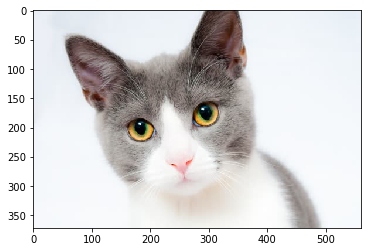

In [4]:
import torch
import torchvision as tv

# библиотека для отрисовки графиков, картинок .... 
import matplotlib.pyplot as plt
%matplotlib inline

# загрузка изображений
from PIL import Image
cat_convolve= Image.open('./imgs/cat_convolve.jpg')
print(cat_convolve.size)
plt.imshow(cat_convolve)

### Превращаем кота в тензор

In [5]:
cat_tensor = tv.transforms.ToTensor()(cat_convolve)
print (cat_tensor.size())

torch.Size([3, 372, 560])


### Сворачиваем картинку ядром, детектор границ
$$
\begin{bmatrix}
    -1       & -1 & -1  \\
    -1       & 8 & -1 \\
    -1       & -1 & -1
\end{bmatrix}
$$

### Создаем фильтр ядра и заполняем его -1 & 8

In [6]:
filter_kernel = torch.FloatTensor(3,3,3).fill_(-1)
filter_kernel[:,1,1] = 8
print(filter_kernel.size())

torch.Size([3, 3, 3])


### Делаем свертку картинки ядром

Test:  torch.Size([370, 558])


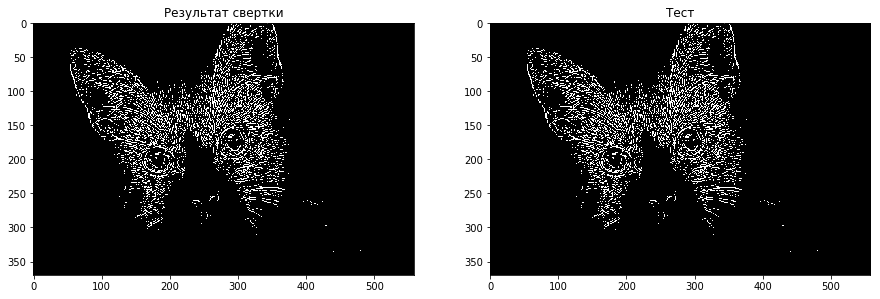

In [7]:
o_image = my_conv2d(cat_tensor, filter_kernel)
o_image[o_image >= 0.5] = 1  # бустим границы
o_image[o_image < 0.5] = 0
test_conv(o_image, './data/kernel_01.pth')

### Горизонтальные границы
$$
\begin{bmatrix}
    1       & 1 & 1  \\
    0       & 0 & 0 \\
    -1       & -1 & -1
\end{bmatrix}
$$

In [8]:
filter_kernel = torch.FloatTensor(3,3,3).fill_(1)
filter_kernel[:,1,:] = 0
filter_kernel[:,2,:] = -1
print(filter_kernel.size())

torch.Size([3, 3, 3])


Test:  torch.Size([370, 558])


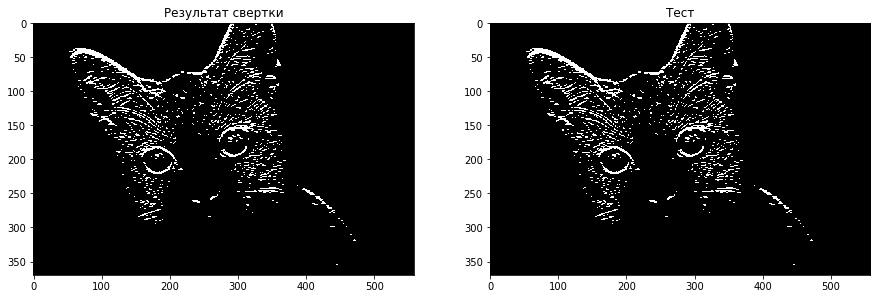

In [9]:
o_image = my_conv2d(torch.unsqueeze(cat_tensor,0), filter_kernel)
o_image[o_image >= 0.5] = 1  # бустим границы
o_image[o_image < 0.5] = 0
test_conv(o_image, './data/kernel_02.pth')

### Вертикальные границы
$$
\begin{bmatrix}
    1       & 0 & -1  \\
    1       & 0 & -1 \\
    1       & 0 & -1
\end{bmatrix}
$$

In [10]:
filter_kernel = torch.FloatTensor(3,3,3).fill_(1)
filter_kernel[:,:,1] = 0
filter_kernel[:,:,2] = -1
print(filter_kernel.size())

torch.Size([3, 3, 3])


Test:  torch.Size([370, 558])


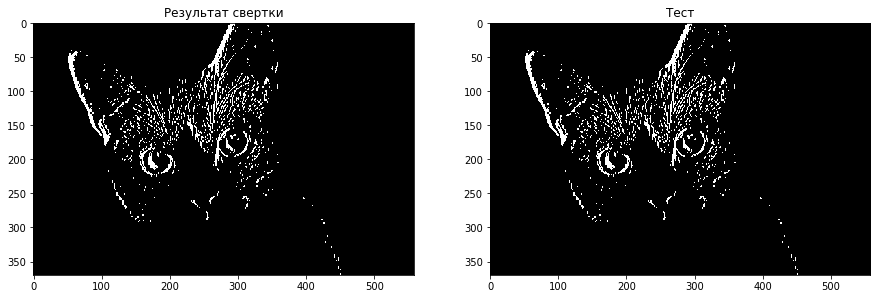

In [11]:
o_image = my_conv2d(cat_tensor, filter_kernel)
o_image[o_image >= 0.5] = 1  # бустим границы
o_image[o_image < 0.5] = 0
test_conv(o_image, './data/kernel_03.pth')

### Используем ядро 

$$ \begin{bmatrix}
    1 & 1 \\
    1 & 1
\end{bmatrix}$$

### и stride 2

Test:  torch.Size([186, 280])
torch.Size([186, 280])


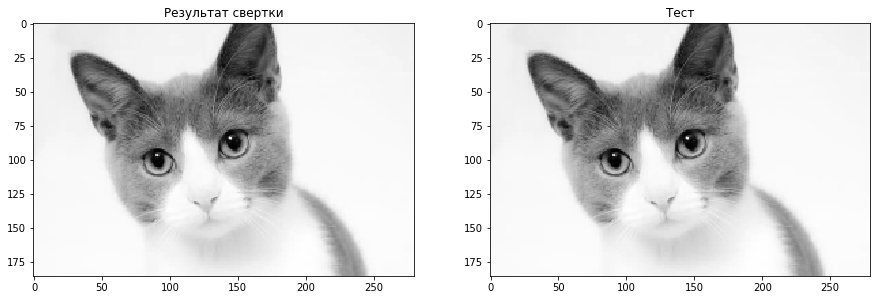

In [12]:
filter_kernelx2 = torch.FloatTensor(3,2,2).fill_(1)
o_image = my_conv2d(cat_tensor, filter_kernelx2, stride=(2,2))
o_image /= 4 # усредняем
torch.save(o_image, './data/kernel_05.pth') # тут проверочный выход читанем его
test_conv(o_image, './data/kernel_05.pth')
assert o_image.size() == torch.Size([186, 280]), 'Размер выходного изображения не совпадает с размером теста'
print(o_image.size())
plt.imshow(o_image.numpy(), cmap='gray')

### Используем ядро 

$$ \begin{bmatrix}
    1 & 1 & 1 \\
    1 & 1 & 1 \\
    1 & 1 & 1
\end{bmatrix}$$

### и stride 1, padding 1

Test:  torch.Size([372, 560])


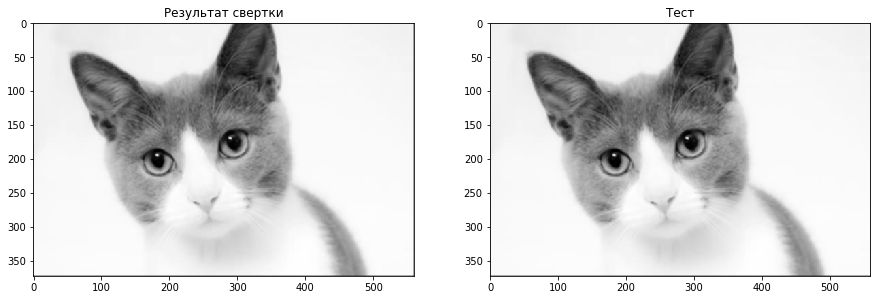

In [13]:
filter_kernelx2 = torch.FloatTensor(3,3,3).fill_(1)
o_image = my_conv2d(cat_tensor, filter_kernelx2, stride=(1,1), padding=(1,1))
o_image /= 4 # усредняем
#torch.save(o_image, './data/kernel_04.pth') # тут проверочный выход читанем его
test_conv(o_image, './data/kernel_04.pth')

### Используем ядро 

$$ \begin{bmatrix}
    1 & 1 & 1 \\
    1 & 1 & 1 \\
    1 & 1 & 1
\end{bmatrix}$$

### и stride 2, padding 2

Test:  torch.Size([187, 281])


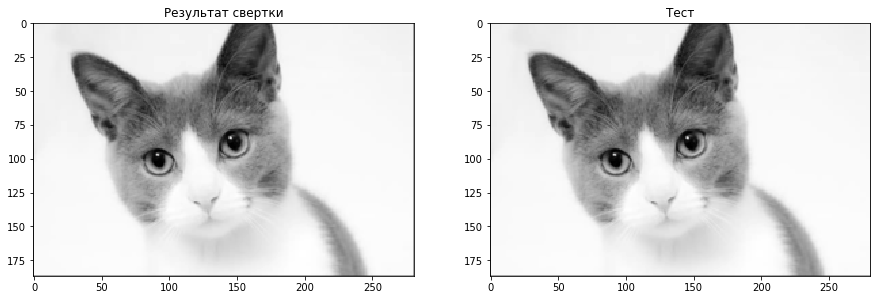

In [14]:
filter_kernelx2 = torch.FloatTensor(3,3,3).fill_(1)
o_image = my_conv2d(cat_tensor, filter_kernelx2, stride=(2,2), padding=(2,2))
o_image /= 4 # усредняем
test_conv(o_image, './data/kernel_06.pth')

### Ядро свертки с гаусовым распределением

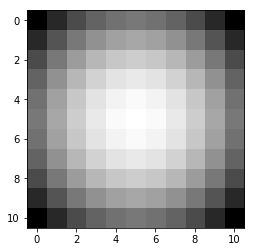

In [15]:
import scipy.ndimage as ndi
import numpy as np
sigma = 10    # параметр распределение
patern_size = 101 # максимальный размер ядра свертки
kernel_size = 10  # реальный размер свертки
x = np.zeros((patern_size, patern_size))
x [patern_size//2,patern_size//2]= 1

# делаем ядро с гаусовым распределением
gause_kernel = ndi.filters.gaussian_filter(x, sigma=sigma)
# вырезаем из центра наш кернел
gause_kernel = gause_kernel[(patern_size//2-(kernel_size//2)):(patern_size//2+(kernel_size//2))+1, \
                (patern_size//2-(kernel_size//2)):(patern_size//2+(kernel_size//2))+1]
# вот он
plt.imshow(gause_kernel, interpolation='none', cmap=plt.get_cmap('gray'))

# Делаем сверку 

torch.Size([362, 550])
Test:  torch.Size([362, 550])


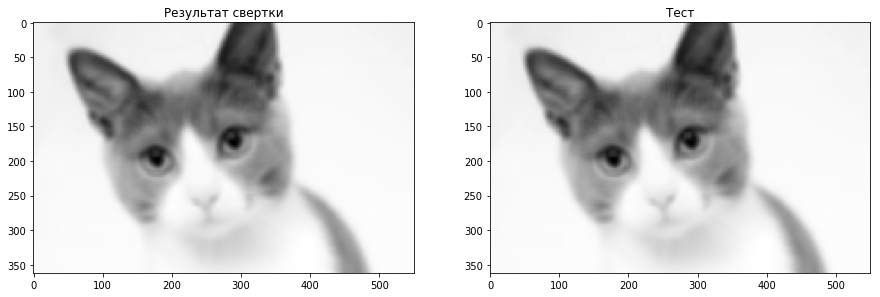

In [16]:
o_image = my_conv2d(cat_tensor, torch.from_numpy(gause_kernel).float().unsqueeze(0))
print(o_image.shape)
test_conv(o_image, './data/kernel_07.pth', False)

# Написать модуль батч нормализации для картинок
<img src="./imgs/37.png" width=400>

- Как выглядит формула финальной батч нормализации в слое при прямом проходе в процессе тренеровки сети, используем формулу для экспоненциального скользящего среднего:
$$
\large
\begin{align}
v_t = \beta \times v_{t-1} + (1-\beta)\times \mu_t \leftarrow для \ каждой \ ФИЧИ \ в \ батче \ расчитываем \ ее \ среднее \\ 
s_t = \beta \times s_{t-1} + (1-\beta)\times \sigma^2_t \leftarrow для \ каждой \ ФИЧИ \ в \ батче \ расчитываем \ ее \ дисперсию \\ \\
\hat{\mathbf{x}} = \frac{\mathbf{x_t} - \mu}{ \sqrt{\sigma^2 + \epsilon}} \times \gamma + b \leftarrow финальная \ формула \ для \ расчета  \ выхода\ слоя \ в \ режиме\ тренировки
\end{align}
$$

где $ \large \gamma, b $ - параметры, афинного преобразования, размерность - количество фичей во входном тензоре, эти параметры обучаются вместе с батч нормализацией

- Как выглядит правило для расчета выхода в процессе инференса:
$$
\large
\begin{align}
\hat{\mathbf{x}} = \frac{\mathbf{x_t} - v_t}{ \sqrt{s_t + \epsilon}} \times \gamma + b \leftarrow финальная \ формула \ для \ расчета  \ выхода\ слоя
\end{align}
$$

$\large s_t, v_t, \\ параметры считаются в процессе тренировки
\gamma, b $ - обучаемые параметры параметры.

### Задание:
Реализовать модуль 2d батч нормализации и проверить его работу на входных изображениях.

P.S. Каждый канал входной картинки считается отдельной фичёй (компонентом векторв)

Нужные функции
```python
import torch
torch.zeros - создать тензор заполненный нулями
torch.ones - создать тензор заполненный единицами
torch.Tensor - создать тензор(1, in_channels, 1, 1)
torch.mean, torch.var  - среднее и дисперсия
x.uniform_ - заполнить тензор случайными числами из равномерного распределения
y.expand_as(x) - разширить тензор y до размера x, по расширяемым направлениям размерность тензора x должна быть равна 1
x.unsqueeze(dim) - добавить размерность в тензор
x.squeeze - убрать размерность

```

In [92]:
import torch.nn as nn


class BatchNorm2d(nn.Module):
    
    def __init__(self, in_channels, afine=True, beta=0.9, epsilon=1e-8):
        """
         Инициализация BN
         Если задан флаг afine -- инициализируем матрицы гамма (weights) и b (bias)
         
        :param in_channels: количество входных каналов предыдущего слоя
        :param afine: делать ли афинное преобразование в процессе обучения.
        :param beta: параметр сглаживания
        :param epsilon: параметр исключающий деление на ноль
        """
        super().__init__()
        
        self.runing_mean=torch.zeros([1, in_channels, 1, 1], dtype=torch.float)
        self.runing_var=torch.ones([1, in_channels, 1, 1], dtype=torch.float)
        
        self.in_channels = in_channels
        self.training = True
        self.beta = beta
        self.epsilon = epsilon
        self.afine = afine
        
        self.weights = None
        self.bias = None
        
#         if afine:
#             #Инициализируем матрицу весов равномерным распределением. Смещений - нулями.
#         self.weights = torch.FloatTensor(1, in_channels, 1, 1).uniform_(0, 1)
        self.weights = torch.ones([1,in_channels,1,1],dtype=torch.float).uniform_()
        self.bias = torch.zeros([1, in_channels, 1, 1], dtype=torch.float)

        
    def forward(self, x):
        """
        Считаем параметры нормализации в режиме обучения, всегда нормализуем x.
        Параметры gamma и b **обучаемые** , 
        т.е. учитываем, что эти параметры должны быть обучены в процессе тренировки. 
        ФИЧИ - среднее значения пикселя в каждом отдельном канале. 
        
        """
        # Способ #1 
        # X tensor размера (batch_size, in_chanels, H,W) 
        if x.dim() != 4:
            x = torch.unsqueeze(x, 1) # add channel dimension
        
        x=x.float()
        batch_size, channels, H, W = x.shape
#         try:
#             batch_mean = torch.mean(x, dim=(0,2,3) , keepdim=True)
#             batch_var = torch.mean((x - batch_mean) ** 2, dim=(0,2,3), keepdim=True)
#         except TypeError:
            #For older PyTorch versions. 
            # Transform X to shape (channels, batch_size * H * W)
        batch_mean = x.view(batch_size, channels, H * W).permute(1,0,2).contiguous()\
                    .view(channels, batch_size*H*W).mean(dim=1, keepdim=True).reshape(1, channels, 1, 1)
        batch_var = x.view(batch_size,channels, H * W).permute(1,0,2).contiguous()\
                    .view(channels,batch_size*H*W).var(dim=1, keepdim=True).reshape(1, channels, 1, 1)

        if self.training:
            # In trainnig mode
            x_norm = (x - batch_mean) * 1. / torch.sqrt (batch_var + self.epsilon)
            
            self.runing_mean = self.beta*self.runing_mean + (1 - self.beta)*batch_mean
            self.runing_var = self.beta*self.runing_var + (1 - self.beta)*batch_var
        else:
            x_norm = (x - self.runing_mean) / torch.sqrt (self.runing_var \
                                                        + self.epsilon)
        if self.afine: 
            return x_norm * self.weights + self.bias

        return x_norm

### Проверяем работу батч нормализации на котэ

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([372, 560, 3])
Test:  torch.Size([372, 560, 3])


AssertionError: Что-то пошло не так, тест не пройден

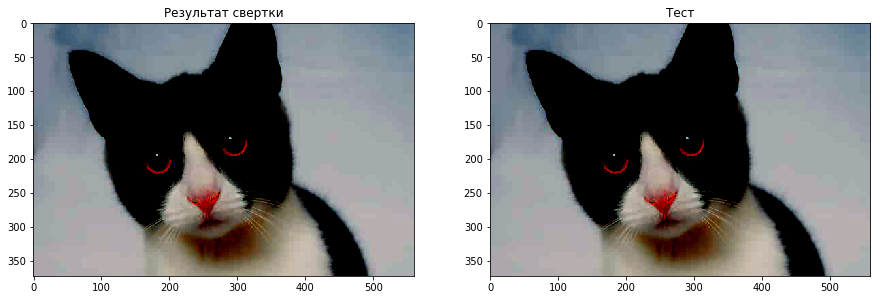

In [93]:
# Без афинных преобразований, за один проход не должно быть значительных изменений, 
#потому что начальные значеня среднего 0 и дисперсии 1 
bn = BatchNorm2d(3, afine=False)
assert bn.training # проверяем, что сеть находится в режиме тренировки

# добавляем размерность батча
o_image = bn(cat_tensor.unsqueeze(0))

# убираем размерность батча
o_image = o_image.squeeze()

# транспонирование тензора картинки картинки
# для того, чтобы его мог отрисовать matplot
o_image = o_image.transpose(0,2).transpose(0,1)
print(o_image.size())
test_conv(o_image, './data/bn_01.pth')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Test:  torch.Size([372, 560, 3])


AssertionError: Что-то пошло не так, тест не пройден

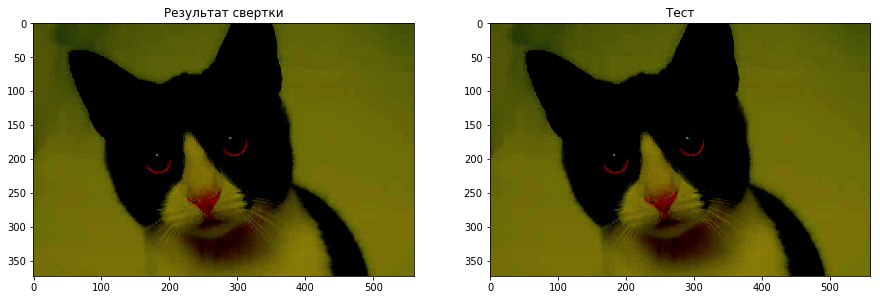

In [78]:
# C афинными преобразованиями, должен нагладыватья uniform_ шум при каждом новом запуске
# Поэтому, чтобы получить детерменированный результат устанавливаем seed
torch.manual_seed(999)

bn = BatchNorm2d(3, afine=True)
assert bn.training # проверяем, что сеть находится в режиме тренировки
# добавляем размерность батча
o_image = bn(cat_tensor.unsqueeze(0))
# убираем размерность батча
o_image = o_image.squeeze()

# транспонирование тензора картинки картинки
# для того, чтобы его мог отрисовать matplot
o_image = o_image.transpose(0,2).transpose(0,1)
test_conv(o_image, './data/bn_02.pth')
#print (o_image.size())

### Проверим как реализация работает на большом сете картинок
Цель проверить расчет running_mean and running_var, эти переменные мы расчитываем в режиме тренировки

In [79]:
torch.__version__

'1.0.1.post2'

In [94]:
import numpy as np
import matplotlib.pylab as plt
%matplotlib inline

In [95]:
# Загружаем MNIST
from sklearn.datasets import fetch_mldata
mnist = fetch_mldata('MNIST original', data_home='./')
X = mnist['data']
# переходим к формату тензоров pytorch
X = X.reshape((-1, 1, 28, 28))
X = X.astype('float')
print(X.shape)

(70000, 1, 28, 28)


/home/zakajd/anaconda3/envs/dl/lib/python3.7/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function fetch_mldata is deprecated; fetch_mldata was deprecated in version 0.20 and will be removed in version 0.22
  warnings.warn(msg, category=DeprecationWarning)
/home/zakajd/anaconda3/envs/dl/lib/python3.7/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function mldata_filename is deprecated; mldata_filename was deprecated in version 0.20 and will be removed in version 0.22
  warnings.warn(msg, category=DeprecationWarning)


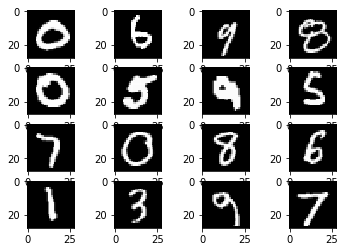

In [96]:
n=4
for i in range(n*n):
    plt.subplot(n,n,i+1)
    I = X[np.random.randint(0, X.shape[0]),0]
    plt.imshow(I, cmap='gray')

### Тестируем модуль батч нормализации на мнисте
Прогоняем весь поток картинок (1 эпоха) с размером батча 32, и смотрим как расчитываются скользящее среднее значение в процессе тренировки

In [97]:
# функция тестирования BN
def test_batch_norm(bn):
    bn.train(True)
    # количество эпох и размер батча
    c_epoch = 1
    batch_size = 32
    # данные для отчета
    mean_curve = []
    var_curve = []
    np.random.seed(999)
    for iter in range(c_epoch):
        Xperm = np.random.permutation(X.shape[0])
        loss_acc = 0
        nbatches = X.shape[0]//batch_size
        for b in range(nbatches):
            batch_idxs = Xperm[b*batch_size:(b+1)*batch_size]
            x = torch.Tensor(X[batch_idxs])
            bn(x)
            mean_curve += [ bn.runing_mean ] 
            var_curve +=  [ bn.runing_var ]
    return mean_curve, var_curve

In [98]:
torch.manual_seed(999)
# параметры beta = 0.9, 0.99, 0.5
bn_09 = BatchNorm2d(1, beta=0.9)
bn_099 = BatchNorm2d(1, beta=0.99)
bn_05 = BatchNorm2d(1, beta=0.5)
# ставим обучение в True
bn.train(True)
# количество эпох и размер батча
c_epoch = 1
batch_size = 32
# данные для отчета
mean_curve_09, var_curve_09 = test_batch_norm(bn_09)
mean_curve_099, var_curve_099 = test_batch_norm(bn_099)
mean_curve_05, var_curve_05 = test_batch_norm(bn_05)

BN beta=09


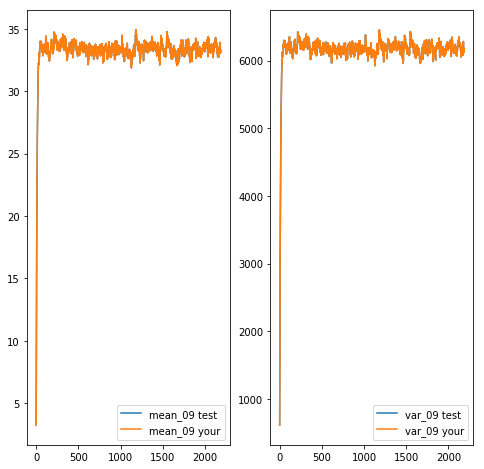

In [99]:
print ("BN beta=09")
test_bn_plots(mean_curve_09, var_curve_09, '09')

BN beta=099


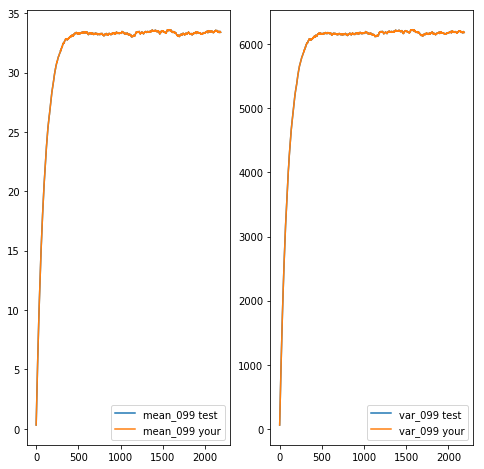

In [100]:
print ("BN beta=099")
test_bn_plots(mean_curve_099, var_curve_099, '099')

BN beta=05


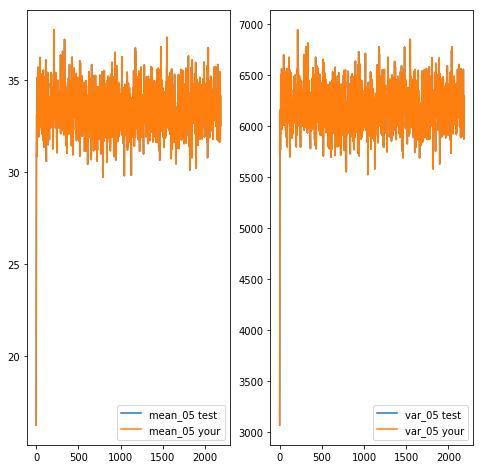

In [101]:
print ("BN beta=05")
test_bn_plots(mean_curve_05, var_curve_05, '05')

Смотрим какие значения средних и дисперсий у нас получились

In [102]:
print ("Проверим, что правильно посчитали среднее и дисперсию при одинаковом seed")
assert int(bn_09.runing_mean[0]) == 33
assert int(bn_099.runing_mean[0]) == 33
assert int(bn_05.runing_mean[0]) == 32
assert int(bn_09.runing_var[0]) == 6136
# здесь получалось на 1 меньше: int(bn_09.runing_var[0]) == 6135
assert int(bn_099.runing_var[0]) == 6180
assert int(bn_05.runing_var[0]) == 6038
print ('ok')

Проверим, что правильно посчитали среднее и дисперсию при одинаковом seed
ok


In [103]:
bn_09.runing_var[0]

tensor([[[6136.0718]]])

Посмотрим как повлияла батч нормализация на изображения

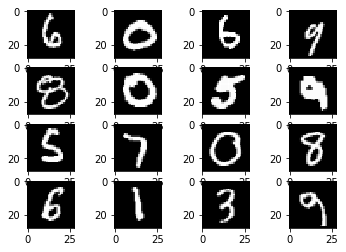

In [105]:
n=4
bn = bn_09
bn.train(False) # эмулируем режим тестирования
np.random.seed(666)
for i in range(n*n):
    plt.subplot(n,n,i+1)
    I = X[np.random.randint(0, X.shape[0]),0]
    x = torch.Tensor(I)
    I = bn(x.unsqueeze(0)).squeeze(0).squeeze()
    # загрузим сохраненный тестовый тензор 
    t_I = torch.load('./data/bn_minst_%2d.pth'%i)
    # проверим, что нормализованный и тестовый тензор совпадают 
    
    #визуально всё хорошо, опять проблемы с точностью.
#     assert (I == t_I).all(), "Что-то не так нормализованный тензор и тестовый не совпадают"
    plt.imshow(I, cmap='gray')

## Done

# Реализуем свой Adam и SGD c моментом

Для реализации своего алгоритма оптимизации в pytorch нужно отнаслеловаться от базового класса Optimizer. При начальной инициализации алгоритма оптимизации он получает в качестве параматра все веса сети. Веса сети можно молучить через 
net.parameters(). По весам сети расчитывается градиент в функции loss.backward(). Веса сети организуются в группы, 
каждая группа образует словарь с сохраненными параметрами обучения, задаются в конструкторе, и самими параметрами, которые доступны по ключу "params". Параметры сети описываются классом Parameters. Для доступа к градиентам используется свойство grad.
Это тензор. Для сохранения параметров оптимизатор имеет свойство state, которое является словарем. Используется для
хранения промежуточных значений средних, дисперсий между шагами итераций.

**Задача** - реализовать функции step() для SGD и Adam, сравнить кривые обучения в зависимости от гиперпараметров (коэффициент обучения, betas), построить графики для различных параметров для каждого алгоритма, сделать выводы о скорости сходимости


## Adam (Adaptive Moment Estimation) 

Adam = SGD + Momentum + RMSProp

$
\large
\begin{align}
m_t &= \alpha \ m_{t-1} + (1 - \alpha)\ g - момент \\ 
v_t &= \beta \ v_{t-1} +  (1-\beta)\ g_{t}^2  - скользящее\ среднее \ по \ квадрату \ градиента \\
\\
\hat{m_t} &= \frac{m_t}{1 - \alpha^t}\\
\hat{v_t} &= \frac{v_t}{1 - \beta^t}\\
\theta_t &= \theta_{t-1} -  \frac{\lambda}{\sqrt{\hat{v_t} + \epsilon}}\hat{m_t} \\
\ выразим\ step\_size \ через \ \alpha \ и \ \beta \\
\ step\_size =  \lambda \frac {({1 - \beta^t})^{\frac{1}{2}}}{{1 - \alpha^t}} \\ 
\theta_t &= \theta_{t-1} -  \frac{step\_size}{\sqrt{v_t + \epsilon}}\times m_t 
\end{align}
$


In [129]:
from torch.optim import Optimizer
import math

class Adam(Optimizer):
    def __init__(self, params, lr=1e-3, betas=(0.9, 0.999), eps=1e-8):
        """
        :param params: - параметры оптимизируемой сети
        :param betas: - коэффициенты сглаживания
        :param eps: - 
        """
        defaults = dict(lr=lr, betas=betas, eps=eps)
        # тут вызываем конструктор базового класса и сохраняем параметры обучения
        # их можно достать через self.param_groups
        super(Adam, self).__init__(params, defaults)
        
#         self.t = 0

    def step(self):
        """
        Выполняем оптимизационный шаг
        """
        loss = None

        for group in self.param_groups:
            # итерируемся по всем группам параметров нашей сети
            # тут можно вытащить сохраненные параметры в группе
            beta1, beta2 = group['betas'] 
            eps = group['eps']
            
            lr = group['lr']
            for p in group['params']:
                # итерируемся по всем парамерам в данной группе
                # если нет градиента по параметрам скипаем его
                if p.grad is None:
                    continue
                # забираем тензор градиента    
                grad = p.grad.data
                
                # тут храняться значения, которые мы расчитываем в процессе 
                # по каждому параметру в группе нужно расчитывать свои значения
                state = self.state[p]

                # если параметры мы еще не записали инициализируем их значения
                if len(state) == 0:
                    state['step'] = 0
                    # скользящее среднее по градинтам
                    state['exp_avg'] = torch.zeros_like(p.data)
                    # скользящее среднее по квадрату градиентов
                    state['exp_avg_sq'] = torch.zeros_like(p.data)

                exp_avg, exp_avg_sq = state['exp_avg'], state['exp_avg_sq']
                        
                # запоминаем шаг
                state['step'] += 1

                # Считаем параметры. Записывать обратно в state не нужно, ибо мы получаем ссылку
                exp_avg = beta1 * exp_avg + (1 - beta1) * grad #?? 
                exp_avg_sq = beta2 * exp_avg_sq + (1 - beta2) * torch.pow(grad,2)
                
#                 exp_avg_unbias = exp_avg / (1 - beta1 ** state['step']) # m_hat ???
#                 exp_avg_unbias = exp_avg_sq / (1 - beta2 ** state['step']) #v_hat       
#                 state -= lr * first_unbias / (torch.sqrt(second_unbias + eps)) 
                
                step_size = lr * np.sqrt(1 - beta2 ** state['step'])/ (1 - beta1 ** state['step'])                
                # обновляем веса в p.data
                p.data -= step_size * exp_avg / (torch.sqrt(exp_avg_sq + eps)) 

        return loss

## SGD + Momentum
$$
\Large
\begin{align}
g_t &= \nabla_{\theta} \overset{\wedge}{\large J}\left(x,y,\theta \right) - градиент \\
m_t &= \beta m_{t-1} - (1- \beta) g_t, \ где \  \beta - параметр\ обучения \\
m_t &= \alpha m_{t-1} - \lambda g_t, \ альтернативная \ форма \ записи \\
\theta_t &= \theta_{t-1} + m_t
\end{align}
$$

In [120]:

class SGD(Optimizer):
    def __init__(self, params, lr, beta=0.9):
        """
        :param params: - параметры оптимизируемой сети
        :param beta: - коэффициент сглаживания
        :param eps: - 
        """        
        defaults = dict(lr=lr, beta=beta)
        # тут вызываем конструктор базового класса и сохраняем параметры обучения
        # их можно достать через self.param_groups 
        super(SGD, self).__init__(params, defaults)

    def step(self):
        """
        Выполняем оптимизационный шаг
        """

        loss = None

        for group in self.param_groups:
            # итерируемся по всем группам параметров нашей сети
            # тут можно вытащить сохраненные параметры в группе            
            beta = group['beta']
            lr=group['lr']
            for p in group['params']:
                if p.grad is None:
                    continue
                    
                d_p = p.grad.data
                
                # тут добавляем момент если beta != 0
                if beta != 0:
                    state = self.state[p]

                    # если параметры мы еще не записали инициализируем их значения
                    if 'momentum' not in state:
                        momentum = state['momentum'] = torch.zeros_like(p.data)

                    momentum = state['momentum']
                    momentum= beta * momentum - (1 - beta) * d_p
                    d_p -= momentum

                # обновляем веса p.data
                # to do
                p.data -= d_p
        return loss


Тут векторизуем наш выход как OneHotEncoder вектор. Если объект принадлежит классу значение 1 нет 0.

In [121]:
from sklearn.preprocessing import OneHotEncoder

Y = mnist['target'].astype('int')
print('original', Y)


original [0 0 0 ... 9 9 9]


In [122]:
#у меня не получилось установить CUDA
# USE_CUDA = False
USE_CUDA = True

## Определение нашей модели
Параметры инициализации
- Без параметров - конволюции и активации
- dropout = True - c dropout
- batchnorm = True - включаем  batch normalization

In [123]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):

    # Слои, в которых нет параметров для обучения можно не создавать, а брать из переменной F
    def __init__(self, dropout=False, batchnorm=False):
        super(Net, self).__init__()
        #
        # спецальный модуль, который позволяет 
        # объединять компоненты
        self.net = nn.Sequential(nn.BatchNorm2d(1))
        
        # вход 28x28, выход 24x24 (28-5)/1 + 1 = 24
        self.net.add_module('conv_1', nn.Conv2d(1, 8, kernel_size=5, stride=1))
        # добавляем бн
        if batchnorm: self.net.add_module('bn_1', nn.BatchNorm2d(8))
        self.net.add_module('relu_1', nn.ReLU())  
        
        # добавляем дропаут
        if dropout: self.net.add_module('do_1', nn.Dropout(0.5))            
        
        # конволюция, которая уменьшает размер картинки в два раза 
        # (24-2)/2+1 = 12, либо используем nn.MaxPool2d
        self.net.add_module('pool_1', nn.Conv2d(8, 8, kernel_size=2, stride=2)) 
        
        # далее conv->relu->pool
        self.net.add_module('conv_2', nn.Conv2d(8, 16, 5)) # in 12x12, out 8x8
        # добавляем бн
        if batchnorm: self.net.add_module('bn_2', nn.BatchNorm2d(16))
        self.net.add_module('relu_2', nn.ReLU() ) 
        
        # добавляем дропаут
        if dropout: self.net.add_module('do_2', nn.Dropout(0.5))
            
        self.net.add_module('pool_2', nn.MaxPool2d(kernel_size=2, stride=2))
        # Линейный слой классификатора
        self.fc1 = nn.Linear(16 * 4 * 4, 10)
        # relu

    def forward(self, x):
        x = self.net(x)
        # Вытягиваем многомерный тензор катринки в одну линию
        x = x.view(-1, 16 * 4 * 4)
        x = self.fc1(x)
        return x

## Функция обучения модели

In [124]:
def fit_net(c_epoch, network, optimizer):
    loss_fn = torch.nn.CrossEntropyLoss()
    if USE_CUDA:
        loss_fn = loss_fn.cuda()

    batch_size = 32
    loss_curve = []

    for iter in range(c_epoch):
        Xperm = np.random.permutation(X.shape[0])
        loss_acc = 0
        nbatches = X.shape[0]//batch_size
        for b in range(nbatches):
            optimizer.zero_grad()  
            batch_idxs = Xperm[b*batch_size:(b+1)*batch_size]
            x = torch.Tensor(X[batch_idxs])
            y = torch.from_numpy(Y[batch_idxs]).long()
            if USE_CUDA:
                x = x.cuda()
                y = y.cuda()
            y_pred = network(x)
            loss = loss_fn(y_pred, y)
#             loss_acc += float( loss[0] )
            loss_acc += float(loss.item())
            loss.backward()
            optimizer.step()  
        avg_epoch_loss = loss_acc / (nbatches)
        print('Do epoch %s with loss %s' % (iter, avg_epoch_loss ))
        loss_curve.append(avg_epoch_loss)
    
    return loss_curve

## SGD без момента

In [125]:
learning_rate = 1e-1 # 
net = Net(batchnorm=True)
net = net.cuda() if USE_CUDA else net
optimizer = SGD(net.parameters(), lr=learning_rate, beta=0.0)
loss_curve_sgd = fit_net(20, net, optimizer)

Do epoch 0 with loss 2.3095501062256263
Do epoch 1 with loss 2.3080152705427603
Do epoch 2 with loss 2.309025991110154
Do epoch 3 with loss 2.3086338978572476
Do epoch 4 with loss 2.3085418151947916
Do epoch 5 with loss 2.308679401465731
Do epoch 6 with loss 2.3083442147049555
Do epoch 7 with loss 2.308215508790228


KeyboardInterrupt: 

## SGD с моментом

In [126]:
learning_rate = 1e-1
net = Net(batchnorm=True)
net = net.cuda() if USE_CUDA else net
optimizer = SGD(net.parameters(), lr=learning_rate, beta=0.9)
loss_curve_sgd_momentum = fit_net(20, net, optimizer)

Do epoch 0 with loss 0.32413984453590916
Do epoch 1 with loss 0.1548377778985809
Do epoch 2 with loss 0.12050160600249768
Do epoch 3 with loss 0.10664078008313674
Do epoch 4 with loss 0.10137711614915428
Do epoch 5 with loss 0.09612112226936444
Do epoch 6 with loss 0.09238455963423658
Do epoch 7 with loss 0.0884255359420288
Do epoch 8 with loss 0.08715440627914833
Do epoch 9 with loss 0.08549306868048744
Do epoch 10 with loss 0.0823781068909915
Do epoch 11 with loss 0.0831189536794877
Do epoch 12 with loss 0.083288522417626
Do epoch 13 with loss 0.0783454425697682
Do epoch 14 with loss 0.07826031593560737
Do epoch 15 with loss 0.0768982792859978
Do epoch 16 with loss 0.07756498742509663
Do epoch 17 with loss 0.07567842146292308
Do epoch 18 with loss 0.07478554351285106
Do epoch 19 with loss 0.07651945913851833


## Adam

In [130]:
learning_rate = 1e-3
net = Net(batchnorm=True)
net = net.cuda() if USE_CUDA else net
optimizer = Adam(net.parameters(), lr=learning_rate, betas=(0.9, 0.999))

In [131]:
loss_curve_adam = fit_net(20, net, optimizer)

Do epoch 0 with loss 0.2090119083037674
Do epoch 1 with loss 0.07449404376797007
Do epoch 2 with loss 0.06362225391246655
Do epoch 3 with loss 0.05735652273410959
Do epoch 4 with loss 0.05313203571373652
Do epoch 5 with loss 0.05157303210530152
Do epoch 6 with loss 0.04870283587315773
Do epoch 7 with loss 0.046346910151380025
Do epoch 8 with loss 0.045887950353007585
Do epoch 9 with loss 0.04468195831933739
Do epoch 10 with loss 0.042290493512077316
Do epoch 11 with loss 0.041188428431381416
Do epoch 12 with loss 0.03974310775080063
Do epoch 13 with loss 0.03996074695700535
Do epoch 14 with loss 0.038567445351208623
Do epoch 15 with loss 0.03743543524582963
Do epoch 16 with loss 0.038782909028760144
Do epoch 17 with loss 0.03746347466614021
Do epoch 18 with loss 0.03583664146252402
Do epoch 19 with loss 0.03521944629475576


# Кривые обучения

In [ ]:
ax = plt.subplot(1,1,1)
ax.plot(loss_curve_sgd,label="SGD")
ax.plot(loss_curve_sgd_momentum,label="SGD+Momentum")
ax.plot(loss_curve_adam, label='Adam' )
ax.legend()

### Выводы
Тут нужно написать выводы по сравнению скорости сходимлости алгоритмов SGD, SGD + Momentum, ADAM для различных праметров
1. lr - коэффициент обучения для всех элгоритмов (0.1, 0.01, 0.001, 0.0001) при фиксированных остальных гиперпараметрах 
2. beta - для SGD + momentum (0,9, 0,99, 0,5) для лучшего графика в пункте 1.
3. beta1, beta2 - для ADAM - для различных значений (0,9, 0,99, 0,5) для лучшего графика в пункте 1.

TODO